In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import datetime
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Bidirectional, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization, Input, concatenate, K, Reshape, LSTM, CuDNNLSTM
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.utils.np_utils import to_categorical
from keras.losses import *
from sklearn.preprocessing import LabelEncoder, minmax_scale, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras import backend as K
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
%matplotlib inline
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['BITS AIC 2019 - Reflexis Raw Dataset.csv', 'Store Attributes - Store Attributes.csv']


In [2]:
#Objective : Calculate sales/hour for a given system of system and manager scheduled hours
""""The solution should also identify the impact of any
changes made by the manager on the system
generated schedule and determine which
managers make better changes to the system
generated schedule or more generally, what
factors result in better schedule adjustments by
managers vs changes that result in worse / non-
optimal labor schedule & costs.
Objectives : Maximise sales hour
"""

'"The solution should also identify the impact of any\nchanges made by the manager on the system\ngenerated schedule and determine which\nmanagers make better changes to the system\ngenerated schedule or more generally, what\nfactors result in better schedule adjustments by\nmanagers vs changes that result in worse / non-\noptimal labor schedule & costs.\nObjectives : Maximise sales hour\n'

In [3]:
df = pd.read_csv('../input/BITS AIC 2019 - Reflexis Raw Dataset.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df.head()

,STORE,TRAFFIC_ACTUAL,TRANSACTIONS_ACTUAL,SALES_ACTUAL,MANAGER_SCHED_HOURS,SYSTEM_SCHED_HOURS
DATE,,,,,,
2016-01-31,203,180,37,2243.07,26.00,20.50
2016-02-01,203,49,22,424.50,28.50,29.75
2016-02-02,203,85,20,878.20,31.50,25.50
2016-02-03,203,84,25,937.80,25.50,27.50
2016-02-04,203,69,13,572.70,25.75,27.25


In [4]:
null_data = df[df.isnull().any(axis=1)]
#Clean dataframe
if(df.isnull().values.ravel().sum() > 0):
    df = df[pd.notnull(df['EPS'])]    


In [5]:
df.head()

,STORE,TRAFFIC_ACTUAL,TRANSACTIONS_ACTUAL,SALES_ACTUAL,MANAGER_SCHED_HOURS,SYSTEM_SCHED_HOURS
DATE,,,,,,
2016-01-31,203,180,37,2243.07,26.00,20.50
2016-02-01,203,49,22,424.50,28.50,29.75
2016-02-02,203,85,20,878.20,31.50,25.50
2016-02-03,203,84,25,937.80,25.50,27.50
2016-02-04,203,69,13,572.70,25.75,27.25


In [6]:
print('Max sales = ', df['SALES_ACTUAL'].max())
print('Number of records =', len(df))
df.head()

Max sales =  113805.47
Number of records = 121062


,STORE,TRAFFIC_ACTUAL,TRANSACTIONS_ACTUAL,SALES_ACTUAL,MANAGER_SCHED_HOURS,SYSTEM_SCHED_HOURS
DATE,,,,,,
2016-01-31,203,180,37,2243.07,26.00,20.50
2016-02-01,203,49,22,424.50,28.50,29.75
2016-02-02,203,85,20,878.20,31.50,25.50
2016-02-03,203,84,25,937.80,25.50,27.50
2016-02-04,203,69,13,572.70,25.75,27.25


In [7]:

 #Max profit ever made is the max profit it will ever make, Min possible sales made is the minimum it was ever mode(Since we don't have sufficient parameters)


In [8]:
df1 = df.groupby('STORE')
_temp = []
scalar = MinMaxScaler(feature_range=(-1,1))
for store_no, store_data in df1:
    data = df1.get_group(store_no).copy()
    #data['SALES_DELTA_NORM'] = minmax_scale(data['SALES_ACTUAL'], feature_range=(-1, 1))
    
    data['SALES_DELTA_NORM'] = scalar.fit_transform(data['SALES_ACTUAL'].values.reshape(-1,1))
    for i in data['SALES_DELTA_NORM'].values:
        _temp.append(i)
df['SALES_DELTA_NORM'] = _temp

df1 = df.groupby('STORE')
df

,STORE,TRAFFIC_ACTUAL,TRANSACTIONS_ACTUAL,SALES_ACTUAL,MANAGER_SCHED_HOURS,SYSTEM_SCHED_HOURS,SALES_DELTA_NORM
DATE,,,,,,,
2016-01-31,203,180,37,2243.07,26.00,20.50,-0.578366
2016-02-01,203,49,22,424.50,28.50,29.75,-0.888607
2016-02-02,203,85,20,878.20,31.50,25.50,-0.811208
2016-02-03,203,84,25,937.80,25.50,27.50,-0.801040
2016-02-04,203,69,13,572.70,25.75,27.25,-0.863325
2016-02-05,203,53,8,384.50,30.25,31.50,-0.895431
2016-02-06,203,248,43,2110.45,33.00,39.75,-0.600990
2016-02-07,203,147,37,2195.30,20.00,21.50,-0.586515
2016-02-08,203,8,0,0.00,24.50,23.25,-0.961026


In [9]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)
        
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['loss'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        #l = metrics[k]
        l = np.sqrt(scalar.inverse_transform(np.array(metrics[k]).reshape(-1,1)).ravel()).tolist()
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l)
        y = float(l[x])
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('MAPE')
    
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(scalar.inverse_transform(np.array(history.history['loss']).reshape(-1,1)).ravel().tolist())
    plt.plot(scalar.inverse_transform(np.array(history.history['val_loss']).reshape(-1,1)).ravel().tolist())
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [10]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def f1(dfin, store_no, epochs):
#def f1(data, store_no, epochs):
    #predict sales given date, store number, system scheduled hours and manager scheduled hours
    data = dfin.get_group(store_no)
    batch_size = 4
    scalar.fit(data['SALES_ACTUAL'].values.reshape(-1,1))
    #batch_size = 256
    split_date = '2018-01-01'
    X_train, Y_train, X_test, Y_test = data[data.index < split_date][['STORE','MANAGER_SCHED_HOURS','SYSTEM_SCHED_HOURS']], data[data.index < split_date]['SALES_DELTA_NORM'], data[data.index> split_date][['STORE','MANAGER_SCHED_HOURS','SYSTEM_SCHED_HOURS']], data[data.index > split_date]['SALES_DELTA_NORM']
    #X_train, X_test, Y_train, Y_test = train_test_split(data[['STORE','MANAGER_SCHED_HOURS','SYSTEM_SCHED_HOURS']],data['SALES_ACTUAL'], shuffle=False)
    X_train = X_train.values.reshape(X_train.shape[0],1,X_train.shape[1])
    X_test = X_test.values.reshape(X_test.shape[0],1,X_test.shape[1])
    input_shape = (1,X_test.shape[2])
    num_classes = 1
    model = Sequential()
    model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True, input_shape=input_shape)))
    model.add(Dropout(0.25))
    model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True)))
    model.add(Dropout(0.25))
    model.add(Bidirectional(CuDNNLSTM(64)))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation='tanh'))
    model.compile(loss=root_mean_squared_error, optimizer = Adam(lr=0.01), metrics=[root_mean_squared_error])
    history = model.fit(X_train, Y_train.values, epochs = epochs, steps_per_epoch=int(len(X_train) / batch_size), validation_data=(X_test, Y_test.values), validation_steps=max(int(len(X_test)/batch_size),1), callbacks = [MetricsCheckpoint('logs')])
    #history = model.fit(X_train, Y_train.values, epochs = epochs, batch_size = batch_size, validation_data=(X_test, Y_test.values), callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(X_test, Y_test.values)
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    return model
    
#def f2(data):
    #maximize sales, by adjusting sys_hrs and mgr_hrs for f1, output (sys_hrs,mgr_hrs)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 701 samples, validate on 54 samples
Epoch 1/50
175/175 [==============================] - 5s 28ms/step - loss: 0.1469 - root_mean_squared_error: 0.1469 - val_loss: 0.0814 - val_root_mean_squared_error: 0.0814
Epoch 2/50
175/175 [==============================] - 2s 9ms/step - loss: 0.1194 - root_mean_squared_error: 0.1194 - val_loss: 0.0883 - val_root_mean_squared_error: 0.0883
Epoch 3/50
175/175 [==============================] - 2s 9ms/step - loss: 0.1170 - root_mean_squared_error: 0.1170 - val_loss: 0.0801 - val_root_mean_squared_error: 0.0801
Epoch 4/50
175/175 [==============================] - 2s 9ms/step - loss: 0.1159 - root_mean_squared_error: 0.1159 - val_loss: 0.0892 - val_root_mean_squared_error: 0.0892
Epoch 5/50
175/175 [===========

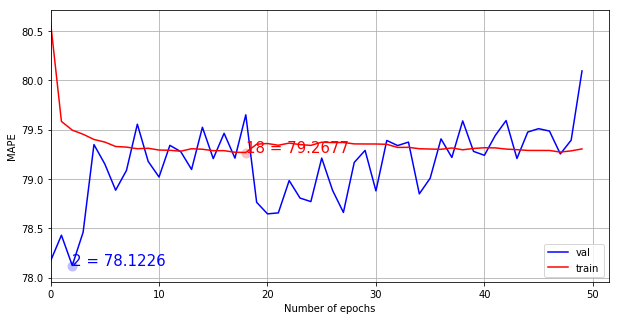

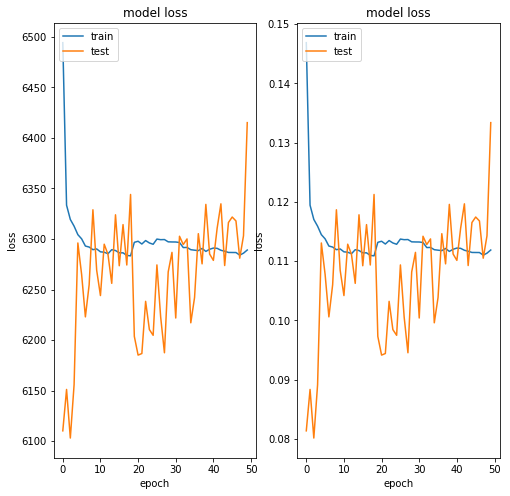

In [11]:
lstm_model = f1(df1, 203, 50)

In [12]:
#General scheme for feature visaulization is to iterate over all possible inputs
store_no = 203
ls1=[]
ls2=[]
dfstore = df1.get_group(store_no)
scalar.fit(dfstore['SALES_ACTUAL'].values.reshape(-1,1))
for i in range(24*7*4+1):
    x_in = np.array([[store_no, float(i)/4.0, float(i)/4.0]])
    x_in = x_in.reshape(x_in.shape[0], 1, x_in.shape[1])
    ls1.append(scalar.inverse_transform(lstm_model.predict(x_in)).tolist()[0])

for j in range(24*7*4+1):
    x_in = np.array([[store_no, float(j)/4.0, float(ls1.index(max(ls1)))/4.0]])
    x_in = x_in.reshape(x_in.shape[0], 1, x_in.shape[1])
    ls2.append(scalar.inverse_transform(lstm_model.predict(x_in)).tolist()[0])
xrange = np.arange(0,24*7+0.25,0.25)        


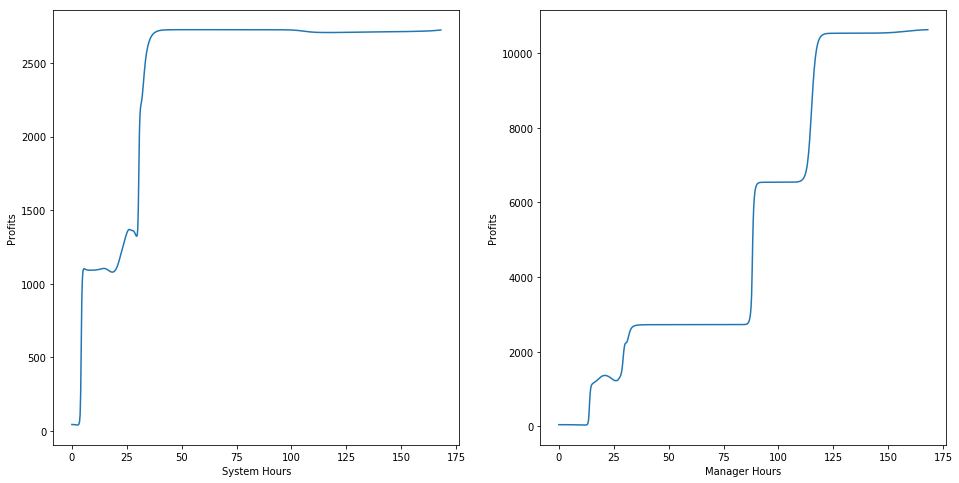

In [13]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(xrange, ls1)
plt.xlabel('System Hours')

plt.ylabel('Profits')
plt.subplot(1,2,2)
plt.plot(xrange, ls2)

plt.xlabel('Manager Hours')

plt.ylabel('Profits')
plt.show()